In [56]:
from bs4 import BeautifulSoup as soup

import requests
import time
import random

search_text = "golang middle"

In [57]:
def wait ():
    sleep_time = {'min': 0.1, 'max': 0.5}
    time.sleep(sleep_time["min"]+(random.random()*(sleep_time["max"]-sleep_time["min"])))

url = "https://nn.hh.ru/search/vacancy"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:91.0) Firefox/91.0",
    "Accept": "*/*",
    "Accept-Language": "ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3",
    "Connection": "keep-alive"
}

params = {
    "clusters": False,
    "ored_clusters": False,
    "enable_snippets": False,
    "salary": None,
    "st": "searchVacancy",
    "text": search_text,
    "page": 0
}

def get_max_page_count():
    
    response = requests.get(url, headers = headers, params = params)
    response_parsed = soup(response.text, 'html.parser')
    

    pager_buttons = response_parsed.select("div[data-qa='pager-block'] a[class='bloko-button'][data-qa='pager-page']")  
    
    max_page_number = 0
    
    for pager_button in (pager_buttons or []):
        number = int(pager_button.get_text())
        max_page_number = number if number > max_page_number else max_page_number
        
    wait()
    print("max page count: ",max_page_number)
    return max_page_number


vacancys_data = []
vacancys_on_page = False 
vacancys_page_count = get_max_page_count()

while params['page'] < vacancys_page_count:
    
    while not vacancys_on_page:
        
        response = requests.get(url, headers = headers, params = params)
        response_parsed = soup(response.text, 'html.parser')

        # ищем блоки с вакансиями и выдергиваем url
        vacancys_on_page = response_parsed.select("div[class=vacancy-serp-item]")  
        vacancys_on_page = (vacancys_on_page if len(vacancys_on_page or [])>0 else False)

        # если нашли вакансии - составляем под них структуры с данными
        if vacancys_on_page:
            for vacancy_block in vacancys_on_page:
                link_container = vacancy_block.select("a[class='bloko-link']")
                vacancys_data.append({"url": link_container[0]['href']})

        print("page ", params['page'], ", count: ", len(vacancys_on_page or []) )
        
        # симулируем
        wait()
        
    vacancys_on_page = False

    params['page'] += 1


max page count:  6
page  0 , count:  20
page  1 , count:  20
page  2 , count:  20
page  3 , count:  20
page  4 , count:  20
page  5 , count:  10


In [58]:
#from deep_translator import GoogleTranslator
import re
import datetime

#translator = GoogleTranslator(source='ru', target='en')
    
def parse_date (raw_text):
    date_text = re.search(r'\d+\s+[^\d\s]+\s+\d+', raw_text or "")
    
    if date_text:
        date_text = date_text.group()

    date_splited = re.split("\s+", date_text)
    #translation = translator.translate(date_splited[-2])
    #translated_month_words = re.split("\s+", translation)
    #translation = translated_month_words[-1]
    
    a_month = ['', 'янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
    month_abbr = re.search(r'^[\w+]{3}', date_splited[-2]).group()
    month_number = a_month.index(month_abbr)
    
    #try:
    #    datetime_object = datetime.datetime.strptime(translation, "%B")
    #except ValueError:
    #    return raw_text
    return datetime.date(int(date_splited[-1]), month_number, int(date_splited[0]))

In [59]:
from price_parser import Price

def process_salary(raw_salary):

    salary_value_strings = re.findall(r'((\d+\s*)+)+', raw_salary)
    salary_sequence = []
    for pair in salary_value_strings: salary_sequence.append(int(re.sub(r'\s+', r'', pair[0])))
    salary_sequence.sort()
    
    print(salary_sequence)
    salary = {
        "from": salary_sequence[0] if len(salary_sequence)>0 else False,
        "to": salary_sequence[1] if len(salary_sequence)>1 else False,
        "gross": False if re.search(r'на\s+руки', raw_salary) else True,
        "currancy":  Price.fromstring(raw_salary).currency
    }

    return salary

In [60]:
import codecs

# разбираем страницу вакансии
counter = 1
for data in vacancys_data:
    
    response = requests.get(data['url'], headers = headers)
    response_parsed = soup(response.text, 'html.parser')    
   
    # вытаскиваем заголовок
    
    title = response_parsed.select("h1[data-qa = 'vacancy-title']")
    data["title"] = str(title[0].get_text()) if len(title)>0 else False
    
    # зарплата бля(
    
    salary_div = response_parsed.select("div[data-qa = 'vacancy-salary']")
    
    #print(counter," of ",len(vacancys_data)," : ", salary_span.get_text())
    counter += 1

    data["salary"] = str(salary_div[0].get_text()) if len(salary_div)>0 else False
    print(process_salary(data["salary"]))
    
    # название компании
    
    company_name_container = response_parsed.select("a[data-qa = 'vacancy-company-name'][class = 'vacancy-company-name'] > span[data-qa = 'bloko-header-2']")
    
    data["company_name"] = company_name_container[0].get_text() if len(company_name_container)>0 else False
    
    # проверенный работодатель
    
    verified_company_link = response_parsed.select("div[class = 'vacancy-company-badge'] > a[class = 'bloko-link'][href = 'https://feedback.hh.ru/article/details/id/5951']")
    data["company_verified"] = True if len(verified_company_link)>=1 else False
    
    # адрес 
    
    full_adress = response_parsed.select("span[data-qa = 'vacancy-view-raw-address']") 
    city_or_smth = response_parsed.select("p[data-qa = 'vacancy-view-location']")
    
    city_or_smth = city_or_smth[0] if len(city_or_smth)>0 else False
    full_adress = full_adress[0] if len(full_adress)>0 else False
        
    data["adress"] = ""
    
    if city_or_smth or full_adress:
        data["adress"] = (city_or_smth or full_adress).get_text()
        
    # режим на объекте
    employment_mode = response_parsed.select("p[data-qa = 'vacancy-view-employment-mode']") 
    data["employment_mode"] = employment_mode[0].get_text() if len(employment_mode)>0 else False
    
    # опыт работы 
    experience = response_parsed.select("span[data-qa = 'vacancy-experience']") 
    data["experience"] = experience[0].get_text() if len(experience)>0 else False
    
    # parttime
    parttime = response_parsed.select("p[data-qa = 'vacancy-view-parttime-options']") 
    data["parttime"] = parttime[0].get_text() if len(parttime)>0 else False

    # accept-temporary
    accept_temporary = response_parsed.select("p[data-qa = 'vacancy-view-accept-temporary']") 
    data["accept_temporary"] = accept_temporary[0].get_text() if len(accept_temporary)>0 else False

    # full_description
    description = response_parsed.select("div[class = 'vacancy-section']") 
    data["description"] = description[0].get_text() if len(description)>0 else False
  
    # дата
    date = response_parsed.select("p[class = 'vacancy-creation-time']") 
    data["creation-time"] = date[0].get_text() if len(date)>0 else False
    
    # тэги 
    tags = response_parsed.select("div[class = 'bloko-tag-list'] > div") 
    tags = tags[0] if len(tags)>0 else False
    
    tag_list = []
    if tags:
        for tag in tags.children:
            tag_list.append(tag.get_text())
    
    data["tag"] = tag_list
    
    # на скорую руку подчищаем вывод
    for key in data:
        if type(key) == type(""):
            data[key] = codecs.encode(str(data[key]),'utf8')
            data[key] = codecs.decode(data[key],'utf8')
    
    data["creation-time"] = parse_date(data["creation-time"])
  

           
    print(counter,"of",len(vacancys_data))
    
    # симулируем
    
    wait()    



[190000]
{'from': 190000, 'to': False, 'gross': False, 'currancy': 'руб.'}
2 of 110
[170000]
{'from': 170000, 'to': False, 'gross': True, 'currancy': 'руб.'}
3 of 110
[130000, 220000]
{'from': 130000, 'to': 220000, 'gross': False, 'currancy': 'руб.'}
4 of 110
[170000]
{'from': 170000, 'to': False, 'gross': False, 'currancy': 'руб.'}
5 of 110
[200000, 300000]
{'from': 200000, 'to': 300000, 'gross': False, 'currancy': 'руб.'}
6 of 110
[150000]
{'from': 150000, 'to': False, 'gross': False, 'currancy': 'руб.'}
7 of 110
[2500]
{'from': 2500, 'to': False, 'gross': False, 'currancy': 'USD'}
8 of 110
[2500, 3000]
{'from': 2500, 'to': 3000, 'gross': False, 'currancy': 'USD'}
9 of 110
[180000]
{'from': 180000, 'to': False, 'gross': False, 'currancy': 'руб.'}
10 of 110
[350000]
{'from': 350000, 'to': False, 'gross': False, 'currancy': 'руб.'}
11 of 110
[]
{'from': False, 'to': False, 'gross': True, 'currancy': None}
12 of 110
[110000]
{'from': 110000, 'to': False, 'gross': True, 'currancy': 'руб.

[]
{'from': False, 'to': False, 'gross': True, 'currancy': None}
100 of 110
[]
{'from': False, 'to': False, 'gross': True, 'currancy': None}
101 of 110
[100000]
{'from': 100000, 'to': False, 'gross': False, 'currancy': 'руб.'}
102 of 110
[]
{'from': False, 'to': False, 'gross': True, 'currancy': None}
103 of 110
[]
{'from': False, 'to': False, 'gross': True, 'currancy': None}
104 of 110
[]
{'from': False, 'to': False, 'gross': True, 'currancy': None}
105 of 110
[120000, 180000]
{'from': 120000, 'to': 180000, 'gross': False, 'currancy': 'руб.'}
106 of 110
[120000, 180000]
{'from': 120000, 'to': 180000, 'gross': False, 'currancy': 'руб.'}
107 of 110
[120000, 180000]
{'from': 120000, 'to': 180000, 'gross': False, 'currancy': 'руб.'}
108 of 110
[]
{'from': False, 'to': False, 'gross': True, 'currancy': None}
109 of 110
[400000, 800000]
{'from': 400000, 'to': 800000, 'gross': False, 'currancy': 'KZT'}
110 of 110
[]
{'from': False, 'to': False, 'gross': True, 'currancy': None}
111 of 110


In [61]:
import pandas as pd

df = pd.DataFrame(columns= list(vacancys_data[0].keys()))

ind = 0
for data in vacancys_data:     
    if (len(df.columns)==len(data)):
        df.loc[ind] = data
        ind+=1

df.to_csv(search_text+".csv", encoding="utf8" )
pd.set_option("display.max_rows",None)
display(df)




,url,title,salary,company_name,company_verified,adress,employment_mode,experience,parttime,accept_temporary,description,creation-time,tag
0,https://nn.hh.ru/vacancy/50939243?from=vacancy...,Middle Go / Golang разработчик,от 190 000 руб. на руки,ООО ФАЙВДЖЕН,False,"Москва, Усачёва улица, 33с2","Полная занятость, полный день",1–3 года,False,False,Привет! Мы занимаемся разработкой сложных и ин...,2022-01-23,['Git']
1,https://nn.hh.ru/vacancy/50009011?from=vacancy...,Backend / Developer Middle Golang,от 170 000 руб. до вычета налогов,ООО ВФМ технолоджи,False,"Москва, Тверская улица, 16с3","Полная занятость, полный день",1–3 года,False,False,"Приглашаем бекенд-разработчикa Golang , которы...",2022-01-22,['Git']
2,https://nn.hh.ru/vacancy/50825858?from=vacancy...,Golang разработчик,от 130 000 до 220 000 руб. на руки,Kvando Technologies,False,Москва,"Полная занятость, удаленная работа",1–3 года,False,"Возможно временное оформление: договор услуг, ...",KVANDO Technologies ЗП: 130 000 - 220 000 р. K...,2022-01-20,['PostgreSQL']
3,https://nn.hh.ru/vacancy/45430651?from=vacancy...,GoLang Middle разработчик,от 170 000 руб. на руки,B2Broker Москва,False,"Москва, Выставочная, Деловой центр, Международная","Полная занятость, гибкий график",1–3 года,False,False,\n\n\n\n\n\n\n\nМеждународная компания B2Broke...,2022-01-21,['Golang']
4,https://nn.hh.ru/vacancy/50835097?from=vacancy...,Middle/Senior Golang developer,от 200 000 до 300 000 руб. на руки,Pushwoosh,False,"Москва, Пресненская набережная, 6с2","Полная занятость, полный день",3–6 лет,False,False,Мы - Pushwoosh – глобальный хайлоад продукт дл...,2022-01-22,['PostgreSQL']
5,https://nn.hh.ru/vacancy/51107108?from=vacancy...,Middle Golang developer / Программист Golang,от 150 000 руб. на руки,Lenvendo,False,"Старая Деревня, Санкт-Петербург, улица Савушки...","Полная занятость, полный день",3–6 лет,False,False,\n\n\n\n\nРазрабатываем и поддерживаем highloa...,2022-01-20,['Golang']
6,https://nn.hh.ru/vacancy/50889327?from=vacancy...,Golang Middle developer,от 2 500 USD на руки,B2Broker Москва,False,Минск,"Полная занятость, гибкий график",1–3 года,False,False,\n\n\n\n\n\n\n\nМеждународная компания B2Broke...,2022-01-22,['Golang']
7,https://nn.hh.ru/vacancy/42992992?from=vacancy...,Golang Middle developer,от 2 500 до 3 000 USD на руки,B2Broker Киев,False,Киев,"Полная занятость, удаленная работа",1–3 года,False,False,\n\n\n\n\n\n\n\nМы — команда молодых и амбицио...,2022-01-21,['SQL']
8,https://nn.hh.ru/vacancy/50737128?from=vacancy...,Golang developer (middle),от 180 000 руб. на руки,ООО ПРОФИТКЛИКС,False,"Краснодар, улица Красных Партизан, 367","Полная занятость, полный день",1–3 года,False,False,"Привет! Мы - ProfitClicks, продуктовая компани...",2022-01-21,['Golang']
9,https://nn.hh.ru/vacancy/49948028?from=vacancy...,Go (Golang) Backend Developer,до 350 000 руб. на руки,evrone.ru,False,Москва,"Полная занятость, полный день",1–3 года,False,False,Команда Evrone занимается продуктовой разработ...,2022-01-21,['Golang']


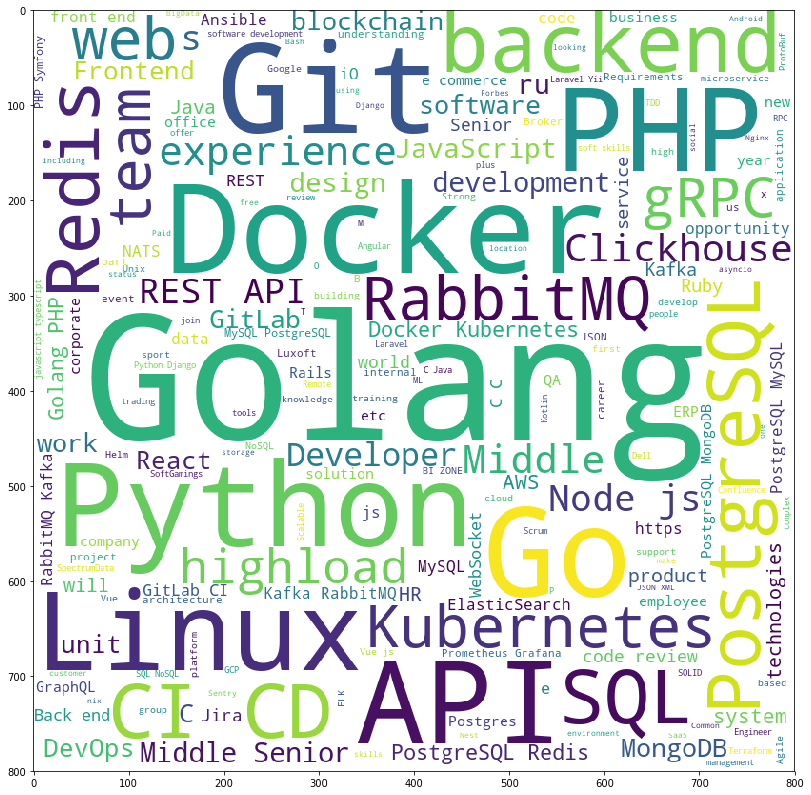

In [62]:
from collections import Counter

vacancy_names = df.tag # change here to change source of data/words etc


descriptions = df.description

import re

additional_tegs = []

for dsc in descriptions:
    searched = re.findall(r"(([A-z]+[\s/-]*)+)+", dsc)
    for pair in searched: additional_tegs.append(list(pair)[0])

#print(additional_tegs)        
    
all_tags = []
for tag in vacancy_names:
    all_tags.append("".join(tag)) 

cloud = Counter(additional_tegs)
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
cloud = ''
for x in list(additional_tegs):
    cloud+=x+' '

wordcloud = WordCloud(width = 800, height = 800, 

                stopwords = stopwords, 
                min_font_size = 8,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (14, 14)) 
plt.imshow(wordcloud)
plt.savefig('vacancy_cloud.png')

In [148]:
! git add *
! git commit -m "fixed salary parsing"
! git push 

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


[main b5fb745] fixed salary parsing
 6 files changed, 11800 insertions(+), 18931 deletions(-)
 rewrite .ipynb_checkpoints/main-checkpoint.ipynb (69%)
 create mode 100644 golang middle.csv
 create mode 100644 golang.csv
 rewrite lua.csv (80%)
 rewrite main.ipynb (84%)
 rewrite vacancy_cloud.png (95%)


remote: This repository moved. Please use the new location:        
remote:   https://github.com/LuaSavage/hh_ru_parser.git        
To https://github.com/russianSlave/hh_ru_parser.git
   e3b9e60..b5fb745  main -> main
